# Complete Input-to-Output Flow in BERT

This notebook traces a complete journey from raw text to final predictions in Mini-BERT.

## What You'll Learn:
1. Text â†’ Tokens â†’ IDs (Tokenization)
2. IDs â†’ Embeddings (Input representation)
3. Embeddings â†’ Hidden states (Transformer processing)
4. Hidden states â†’ Logits (Output projection)
5. Logits â†’ Predictions (Final processing)
6. Shape transformations at each step

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')

from model import MiniBERT
from tokenizer import WordPieceTokenizer
from mlm import mask_tokens

np.random.seed(42)
# Set style for better visualizations - handle version compatibility
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except OSError:
    try:
        plt.style.use('seaborn-darkgrid') 
    except OSError:
        plt.style.use('default')


## Part 1: From Raw Text to Token IDs

The first step is converting human-readable text into numbers the model can process.

Tokenizer loaded from ../tokenizer_8k.pkl (799 tokens)
Raw text: 'The quick brown fox jumps over the lazy dog.'
Length: 44 characters

After tokenization:
Tokens: ['t', 'h', 'e', 'q', 'u', 'i', 'c', 'k', 'b', 'r', 'o', 'w', 'n', 'f', 'o', 'x', 'j', 'u', 'm', 'p', 's', 'o', 'v', 'e', 'r', 't', 'h', 'e', 'l', 'a', 'z', 'y', 'd', 'o', 'g', '.']
Token IDs: [2, 62, 50, 798, 59, 63, 51, 45, 53, 44, 60, 57, 65, 56, 48, 57, 66, 52, 63, 55, 58, 61, 57, 64, 798, 60, 62, 50, 798, 54, 43, 68, 67, 46, 57, 49, 18, 3]
Number of tokens: 38


ValueError: The number of FixedLocator locations (38), usually from a call to set_ticks, does not match the number of labels (36).

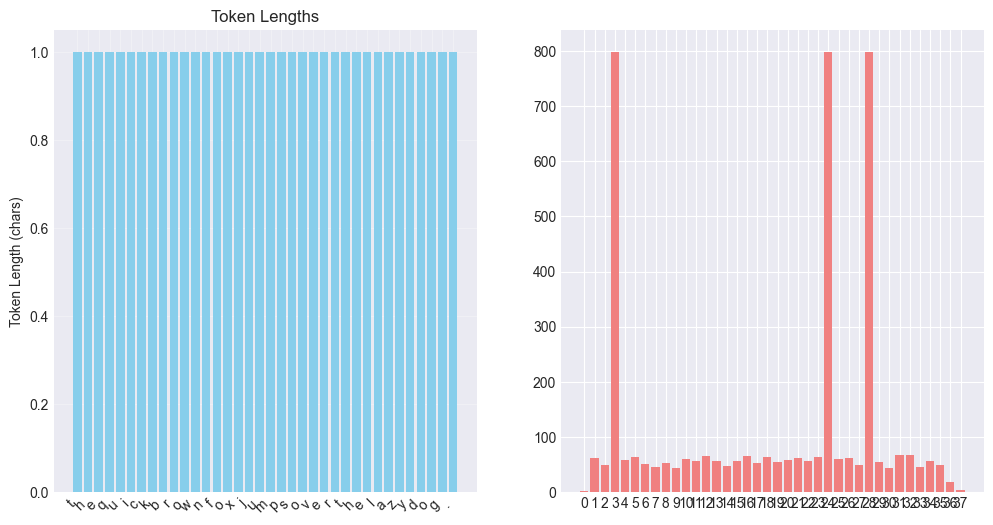

In [2]:
# Load tokenizer
tokenizer = WordPieceTokenizer()
tokenizer.load_model('../tokenizer_8k.pkl')

# Example text
raw_text = "The quick brown fox jumps over the lazy dog."
print(f"Raw text: '{raw_text}'")
print(f"Length: {len(raw_text)} characters")

# Step 1: Tokenization
token_ids = tokenizer.encode(raw_text)
tokens = tokenizer.decode(token_ids).split()

print(f"\nAfter tokenization:")
print(f"Tokens: {tokens}")
print(f"Token IDs: {token_ids}")
print(f"Number of tokens: {len(token_ids)}")

# Visualize token mapping
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(range(len(tokens)), [len(token) for token in tokens], color='skyblue')
plt.xticks(range(len(tokens)), tokens, rotation=45, ha='right')
plt.ylabel('Token Length (chars)')
plt.title('Token Lengths')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(range(len(token_ids)), token_ids, color='lightcoral')
plt.xticks(range(len(token_ids)), tokens, rotation=45, ha='right')
plt.ylabel('Token ID')
plt.title('Token IDs')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Special tokens
print(f"\nSpecial token IDs:")
special_tokens = ['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]']
for token in special_tokens:
    if token in tokenizer.vocab:
        print(f"  {token}: {tokenizer.vocab[token]}")

## Part 2: Token IDs to Embeddings

Token IDs become dense vector representations through embedding lookup.

In [ ]:
# Create model
model = MiniBERT()

# Prepare input (add batch dimension)
input_ids = np.array([token_ids])  # Shape: [1, seq_len]
batch_size, seq_len = input_ids.shape

print(f"Input shape: {input_ids.shape}")
print(f"Batch size: {batch_size}, Sequence length: {seq_len}")

# Step 2a: Token embeddings lookup
token_embeddings = model.params['token_embeddings'][input_ids]  # [batch, seq_len, hidden_size]
print(f"\nToken embeddings shape: {token_embeddings.shape}")

# Step 2b: Position embeddings
position_embeddings = model.params['position_embeddings'][:seq_len]  # [seq_len, hidden_size]
print(f"Position embeddings shape: {position_embeddings.shape}")

# Step 2c: Combine embeddings
input_embeddings = token_embeddings + position_embeddings  # Broadcasting
print(f"Combined embeddings shape: {input_embeddings.shape}")

# Visualize embedding dimensions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Token embeddings heatmap
im1 = axes[0].imshow(token_embeddings[0], cmap='RdBu_r', aspect='auto')
axes[0].set_title('Token Embeddings')
axes[0].set_xlabel('Hidden Dimension')
axes[0].set_ylabel('Token Position')
axes[0].set_yticks(range(len(tokens)))
axes[0].set_yticklabels(tokens)
plt.colorbar(im1, ax=axes[0])

# Position embeddings heatmap
im2 = axes[1].imshow(position_embeddings, cmap='RdBu_r', aspect='auto')
axes[1].set_title('Position Embeddings')
axes[1].set_xlabel('Hidden Dimension')
axes[1].set_ylabel('Position')
plt.colorbar(im2, ax=axes[1])

# Combined embeddings heatmap
im3 = axes[2].imshow(input_embeddings[0], cmap='RdBu_r', aspect='auto')
axes[2].set_title('Combined Embeddings')
axes[2].set_xlabel('Hidden Dimension')
axes[2].set_ylabel('Token Position')
axes[2].set_yticks(range(len(tokens)))
axes[2].set_yticklabels(tokens)
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()

print(f"\nKey insight: Each token now has a {model.config.hidden_size}-dimensional vector")
print(f"that combines word meaning (token embedding) + position info")

## Part 3: Through the Transformer Layers

Now we trace how information flows through each transformer layer.

In [ ]:
def trace_through_layers(model, input_embeddings, detailed=True):
    """Trace input through each transformer layer."""
    
    layer_outputs = {'input': input_embeddings[0].copy()}
    current_hidden = input_embeddings
    
    print("Tracing through transformer layers...")
    print(f"Input shape: {current_hidden.shape}")
    
    # Through each transformer layer
    for layer_idx in range(model.config.num_hidden_layers):
        print(f"\n--- Layer {layer_idx} ---")
        
        # Store input to this layer
        layer_input = current_hidden.copy()
        
        # Multi-head attention
        print(f"  Input to attention: {current_hidden.shape}")
        attn_output, attn_cache = model._multi_head_attention(current_hidden, layer_idx)
        print(f"  Attention output: {attn_output.shape}")
        
        # Residual connection + Layer norm
        current_hidden = current_hidden + attn_output
        print(f"  After residual: {current_hidden.shape}")
        
        gamma = getattr(model, f'ln1_gamma_{layer_idx}')
        beta = getattr(model, f'ln1_beta_{layer_idx}')
        current_hidden = model._layer_norm(current_hidden, gamma, beta)
        print(f"  After layer norm 1: {current_hidden.shape}")
        
        # Feed-forward network
        ffn_input = current_hidden.copy()
        ffn_output = model._feed_forward(current_hidden, layer_idx)
        print(f"  FFN output: {ffn_output.shape}")
        
        # Residual connection + Layer norm
        current_hidden = ffn_input + ffn_output
        print(f"  After residual: {current_hidden.shape}")
        
        gamma = getattr(model, f'ln2_gamma_{layer_idx}')
        beta = getattr(model, f'ln2_beta_{layer_idx}')
        current_hidden = model._layer_norm(current_hidden, gamma, beta)
        print(f"  Final output: {current_hidden.shape}")
        
        # Store layer output
        layer_outputs[f'layer_{layer_idx}'] = current_hidden[0].copy()
        
        if detailed:
            # Show how much the representation changed
            input_norm = np.linalg.norm(layer_input[0])
            output_norm = np.linalg.norm(current_hidden[0])
            change_norm = np.linalg.norm(current_hidden[0] - layer_input[0])
            print(f"  Representation change: {change_norm:.4f} (input norm: {input_norm:.4f}, output norm: {output_norm:.4f})")
    
    return layer_outputs, current_hidden

# Trace through layers
layer_outputs, final_hidden = trace_through_layers(model, input_embeddings)

print(f"\nFinal hidden states shape: {final_hidden.shape}")
print(f"Each token now has a context-aware representation!")

### Visualizing Layer-by-Layer Changes

In [ ]:
# Visualize how representations evolve through layers
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

# Plot representations at different layers
layers_to_show = ['input', 'layer_0', 'layer_1', 'layer_2']
titles = ['Input Embeddings', 'After Layer 0', 'After Layer 1', 'After Layer 2']

for idx, (layer_name, title) in enumerate(zip(layers_to_show, titles)):
    if layer_name in layer_outputs:
        representation = layer_outputs[layer_name]
        
        im = axes[idx].imshow(representation, cmap='RdBu_r', aspect='auto')
        axes[idx].set_title(title)
        axes[idx].set_xlabel('Hidden Dimension')
        axes[idx].set_ylabel('Token Position')
        axes[idx].set_yticks(range(len(tokens)))
        axes[idx].set_yticklabels(tokens)
        plt.colorbar(im, ax=axes[idx])

plt.tight_layout()
plt.show()

# Analyze representation similarity between layers
print("\nLayer-to-layer similarity (cosine similarity):")
for i in range(len(layers_to_show) - 1):
    layer1 = layers_to_show[i]
    layer2 = layers_to_show[i + 1]
    
    if layer1 in layer_outputs and layer2 in layer_outputs:
        repr1 = layer_outputs[layer1].flatten()
        repr2 = layer_outputs[layer2].flatten()
        
        # Cosine similarity
        similarity = np.dot(repr1, repr2) / (np.linalg.norm(repr1) * np.linalg.norm(repr2))
        print(f"  {layer1} â†’ {layer2}: {similarity:.4f}")

## Part 4: From Hidden States to Logits

The final hidden states are projected to vocabulary-sized logits.

In [ ]:
# Apply final layer norm
final_layer_norm = model._layer_norm(final_hidden, model.final_ln_gamma, model.final_ln_beta)
print(f"After final layer norm: {final_layer_norm.shape}")

# Project to vocabulary size (MLM head)
logits = final_layer_norm @ model.mlm_head_weight + model.mlm_head_bias
print(f"\nFinal logits shape: {logits.shape}")
print(f"Batch size: {logits.shape[0]}")
print(f"Sequence length: {logits.shape[1]}")
print(f"Vocabulary size: {logits.shape[2]}")

# Analyze logits
print(f"\nLogits statistics:")
print(f"  Mean: {logits.mean():.4f}")
print(f"  Std: {logits.std():.4f}")
print(f"  Min: {logits.min():.4f}")
print(f"  Max: {logits.max():.4f}")

# Visualize logits for first few tokens
plt.figure(figsize=(15, 8))

# Show logits for first 5 tokens
num_tokens_to_show = min(5, seq_len)
num_top_vocab = 20  # Show top 20 vocabulary items

for i in range(num_tokens_to_show):
    plt.subplot(1, num_tokens_to_show, i + 1)
    
    token_logits = logits[0, i]  # Logits for token i
    
    # Get top predictions
    top_indices = np.argsort(token_logits)[-num_top_vocab:]
    top_logits = token_logits[top_indices]
    
    # Plot
    plt.barh(range(num_top_vocab), top_logits, color='skyblue')
    plt.xlabel('Logit Value')
    plt.title(f'Token: "{tokens[i]}"\nTop {num_top_vocab} Predictions')
    plt.grid(True, alpha=0.3)
    
    # Add vocabulary labels (if possible)
    if hasattr(tokenizer, 'id_to_token'):
        vocab_labels = [tokenizer.id_to_token.get(idx, f'ID_{idx}') for idx in top_indices]
        plt.yticks(range(num_top_vocab), vocab_labels, fontsize=8)

plt.tight_layout()
plt.show()

## Part 5: From Logits to Predictions

Convert logits to probabilities and make predictions.

In [ ]:
def softmax(x, axis=-1):
    """Compute softmax values."""
    exp_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return exp_x / np.sum(exp_x, axis=axis, keepdims=True)

# Convert logits to probabilities
probabilities = softmax(logits)  # [batch, seq_len, vocab_size]
print(f"Probabilities shape: {probabilities.shape}")
print(f"Probabilities sum to 1: {probabilities[0, 0].sum():.6f}")

# Get top predictions for each position
top_k = 5
top_predictions = []

for pos in range(seq_len):
    pos_probs = probabilities[0, pos]  # Probabilities for this position
    
    # Get top-k predictions
    top_indices = np.argsort(pos_probs)[-top_k:][::-1]  # Sort descending
    top_probs = pos_probs[top_indices]
    
    # Try to get token strings
    try:
        top_tokens = [tokenizer.decode([idx]) for idx in top_indices]
    except:
        top_tokens = [f'ID_{idx}' for idx in top_indices]
    
    top_predictions.append({
        'position': pos,
        'input_token': tokens[pos],
        'predictions': list(zip(top_tokens, top_probs, top_indices))
    })

# Display predictions
print("\nTop predictions for each position:")
print("=" * 60)

for pred_info in top_predictions[:5]:  # Show first 5 positions
    pos = pred_info['position']
    input_token = pred_info['input_token']
    
    print(f"\nPosition {pos}: Input token = '{input_token}'")
    print("Top predictions:")
    
    for rank, (pred_token, prob, token_id) in enumerate(pred_info['predictions']):
        percentage = prob * 100
        is_correct = pred_token.strip() == input_token.strip()
        marker = " âœ“" if is_correct else ""
        print(f"  {rank+1}. '{pred_token}' (ID: {token_id}) - {percentage:.2f}%{marker}")

## Part 6: Complete Pipeline with MLM

Let's see the complete pipeline with masked language modeling.

In [ ]:
# Create a masked version of our input
print("Original text:", raw_text)
print("Original tokens:", tokens)

# Apply masking
masked_ids, target_ids, mask_positions = mask_tokens(
    np.array([token_ids]), 
    mask_token_id=tokenizer.vocab['[MASK]'],
    vocab_size=model.config.vocab_size,
    mask_prob=0.15
)

# Decode masked sentence
masked_tokens = tokenizer.decode(masked_ids[0]).split()
print(f"\nMasked tokens: {masked_tokens}")
print(f"Mask positions: {mask_positions[0] if len(mask_positions) > 0 else 'None'}")
print(f"Target IDs: {target_ids[0] if len(target_ids) > 0 else 'None'}")

if len(mask_positions) > 0:  # If we have masks
    # Run complete forward pass with masked input
    masked_logits, cache = model.forward(masked_ids)
    masked_probabilities = softmax(masked_logits)
    
    print(f"\nMasked input forward pass:")
    print(f"Input shape: {masked_ids.shape}")
    print(f"Output logits shape: {masked_logits.shape}")
    
    # Analyze predictions at masked positions
    print("\nPredictions for masked positions:")
    print("=" * 50)
    
    for i, pos in enumerate(mask_positions[0]):
        if i < len(target_ids[0]):
            true_token_id = target_ids[0][i]
            true_token = tokenizer.decode([true_token_id])
            
            # Get predictions for this masked position
            pos_probs = masked_probabilities[0, pos]
            top_indices = np.argsort(pos_probs)[-5:][::-1]
            top_probs = pos_probs[top_indices]
            
            print(f"\nMasked position {pos}: True token = '{true_token}'")
            
            for rank, (pred_id, prob) in enumerate(zip(top_indices, top_probs)):
                pred_token = tokenizer.decode([pred_id])
                is_correct = pred_id == true_token_id
                marker = " âœ“" if is_correct else ""
                print(f"  {rank+1}. '{pred_token}' - {prob*100:.2f}%{marker}")
            
            # Show prediction accuracy
            true_token_prob = pos_probs[true_token_id]
            true_token_rank = np.sum(pos_probs > true_token_prob) + 1
            print(f"  True token probability: {true_token_prob*100:.2f}% (rank {true_token_rank})")
else:
    print("\nNo tokens were masked in this example.")
    print("Try running again or increase mask_prob.")

## Part 7: Shape Transformation Summary

Let's summarize all the shape transformations in the pipeline.

In [ ]:
def create_shape_flow_diagram():
    """Create a visual summary of shape transformations."""
    
    # Define the pipeline stages
    stages = [
        ("Raw Text", f"'{raw_text[:30]}...'", f"{len(raw_text)} chars"),
        ("Tokens", f"{tokens[:3]}...", f"{len(tokens)} tokens"),
        ("Token IDs", f"{token_ids[:3]}...", f"[{seq_len}]"),
        ("Batch Input", "Add batch dim", f"[1, {seq_len}]"),
        ("Token Embeddings", "Lookup", f"[1, {seq_len}, 192]"),
        ("+ Position Emb", "Add positions", f"[1, {seq_len}, 192]"),
        ("Layer 0", "Attention + FFN", f"[1, {seq_len}, 192]"),
        ("Layer 1", "Attention + FFN", f"[1, {seq_len}, 192]"),
        ("Layer 2", "Attention + FFN", f"[1, {seq_len}, 192]"),
        ("Final LayerNorm", "Normalize", f"[1, {seq_len}, 192]"),
        ("MLM Projection", "Linear layer", f"[1, {seq_len}, 8192]"),
        ("Probabilities", "Softmax", f"[1, {seq_len}, 8192]")
    ]
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(16, 10))
    
    # Position stages
    y_positions = range(len(stages))
    x_center = 0.5
    
    # Draw boxes and connections
    for i, (stage_name, operation, shape) in enumerate(stages):
        y = len(stages) - 1 - i  # Reverse order (top to bottom)
        
        # Draw box
        box_width = 0.8
        box_height = 0.6
        
        # Color coding
        if 'Layer' in stage_name:
            color = 'lightblue'
        elif 'Embedding' in stage_name or 'Position' in stage_name:
            color = 'lightgreen'
        elif stage_name in ['Raw Text', 'Tokens', 'Token IDs']:
            color = 'lightyellow'
        else:
            color = 'lightcoral'
        
        # Draw rectangle
        rect = plt.Rectangle((x_center - box_width/2, y - box_height/2), 
                           box_width, box_height, 
                           facecolor=color, edgecolor='black', linewidth=1)
        ax.add_patch(rect)
        
        # Add text
        ax.text(x_center, y + 0.1, stage_name, ha='center', va='center', 
                fontweight='bold', fontsize=10)
        ax.text(x_center, y - 0.1, operation, ha='center', va='center', 
                fontsize=8, style='italic')
        ax.text(x_center, y - 0.25, shape, ha='center', va='center', 
                fontsize=9, fontfamily='monospace')
        
        # Draw arrow to next stage
        if i < len(stages) - 1:
            ax.arrow(x_center, y - box_height/2 - 0.05, 0, -0.3, 
                    head_width=0.03, head_length=0.05, fc='black', ec='black')
    
    # Set limits and remove axes
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.5, len(stages) - 0.5)
    ax.set_aspect('equal')
    ax.axis('off')
    
    plt.title('Complete BERT Input-to-Output Flow\nShape Transformations', 
              fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

# Create the diagram
create_shape_flow_diagram()

# Print summary table
print("\n" + "="*80)
print("SHAPE TRANSFORMATION SUMMARY")
print("="*80)
print(f"{'Stage':<20} {'Input Shape':<15} {'Output Shape':<15} {'Key Operation':<25}")
print("-" * 80)

transformations = [
    ('Tokenization', 'Text', f'[{seq_len}]', 'String â†’ Token IDs'),
    ('Batching', f'[{seq_len}]', f'[1,{seq_len}]', 'Add batch dimension'),
    ('Token Embedding', f'[1,{seq_len}]', f'[1,{seq_len},192]', 'ID â†’ Dense vector'),
    ('Position Embedding', f'[1,{seq_len},192]', f'[1,{seq_len},192]', 'Add position info'),
    ('Transformer x3', f'[1,{seq_len},192]', f'[1,{seq_len},192]', 'Self-attention + FFN'),
    ('MLM Head', f'[1,{seq_len},192]', f'[1,{seq_len},8192]', 'Project to vocab'),
    ('Softmax', f'[1,{seq_len},8192]', f'[1,{seq_len},8192]', 'Logits â†’ Probabilities')
]

for stage, input_shape, output_shape, operation in transformations:
    print(f"{stage:<20} {input_shape:<15} {output_shape:<15} {operation:<25}")

print("\nKey Insights:")
print("â€¢ Hidden dimension (192) stays constant through transformer layers")
print("â€¢ Only the final projection changes the last dimension")
print("â€¢ Batch and sequence dimensions are preserved throughout")
print("â€¢ Each position gets independent predictions")

## Summary: Complete Journey

### **The Complete Pipeline**
1. **Text â†’ Tokens**: "Hello world" â†’ ["Hello", "world"]
2. **Tokens â†’ IDs**: ["Hello", "world"] â†’ [1234, 5678]
3. **IDs â†’ Embeddings**: [1234, 5678] â†’ Dense vectors
4. **Through Transformers**: Context-aware representations
5. **To Vocabulary**: Project back to vocabulary space
6. **To Predictions**: Softmax â†’ Probabilities

### **Key Shape Transformations**
- **[text] â†’ [seq_len] â†’ [1, seq_len] â†’ [1, seq_len, 192] â†’ [1, seq_len, 8192]**

### **What Each Component Does**
- **Embeddings**: Convert discrete â†’ continuous
- **Transformers**: Add context awareness
- **Output projection**: Map back to vocabulary
- **Softmax**: Convert to probabilities

### **Why This Design Works**
- **Constant hidden size**: Allows deep stacking
- **Residual connections**: Enable gradient flow
- **Attention**: Captures long-range dependencies
- **Position embeddings**: Preserve order information

## Exercises

1. **Different Texts**: Try the pipeline with different input texts. How do the representations change?

2. **Layer Analysis**: Compare representations at different layers. Which layers capture which types of information?

3. **Attention Patterns**: Extract and visualize attention weights. What patterns do you see?

4. **Vocabulary Analysis**: Which tokens does the model predict most confidently? Why?

In [ ]:
# Space for your experiments
# Try different texts here:
# different_text = "Your text here"
